# USA Data Processing
This notebook processes historical balancing authority data to estimate transmission line capacity between regions

In [15]:
import pandas as pd 
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
from itertools import permutations, combinations
import matplotlib.pyplot as plt
import requests
from pathlib import Path
import zipfile

## Helper Functions

In [2]:
def download_file(url: str, destination: str):
    response = requests.get(url)
    
    if response.status_code == 200:
        with open(destination, 'wb') as file:
            file.write(response.content)
        print(f"File downloaded successfully to {destination}")
    else:
        print(f"Failed to download file. Status code: {response.status_code}")

In [3]:
def file_exists(file_path: str):
    path = Path(file_path)
    return path.is_file()

In [16]:
def extract_zip(zip_file_path: str, extract_to: str):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"Zip file '{zip_file_path}' extracted successfully to '{extract_to}'")

## Get Balancing Authority Shapes 
Shapes are taken from [Electricity Maps](https://github.com/electricitymaps/electricitymaps-contrib/blob/master/web/geo/world.geojson), as they have a spatially resolved file (ie. no overlaps between balancing authorities)

In [13]:
geojson = "world.geojson"

if not file_exists(geojson):
    url = "https://raw.githubusercontent.com/electricitymaps/electricitymaps-contrib/master/web/geo/world.geojson"
    download_file(url, geojson)

gdf = gpd.read_file(geojson)
gdf = gdf[gdf["countryKey"] == "US"]
gdf.head(5)

File downloaded successfully to world.geojson


zoneName countryKey    countryName  \
287        US-AK         US  United States   
288  US-CAL-BANC         US  United States   
289  US-CAL-CISO         US  United States   
290   US-CAL-IID         US  United States   
291  US-CAL-LDWP         US  United States   

                                              geometry  
287  MULTIPOLYGON (((-139.06039 59.99977, -139.1827...  
288  MULTIPOLYGON (((-123.03663 40.36388, -122.6946...  
289  MULTIPOLYGON (((-123.39303 41.16099, -123.4794...  
290  MULTIPOLYGON (((-114.75544 32.64156, -114.5261...  
291  MULTIPOLYGON (((-118.65899 34.16872, -118.3961...

<Axes: >

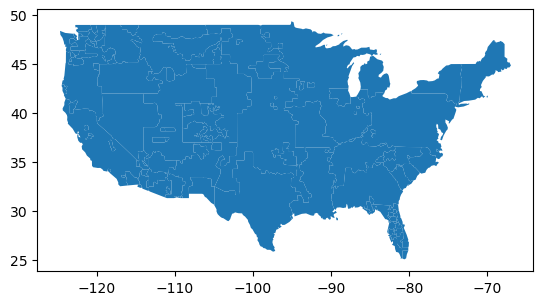

In [14]:
bas = gdf.copy()
bas["region"] = bas["zoneName"].map(lambda x: x.split("-")[1])
bas = bas[~bas["region"].isin(["AK", "HI"])].drop(columns=["region"]) # drop alaska and hawaii
bas.plot()

## Get Population Data
Population data comes from the [World Cities Database](https://simplemaps.com/data/world-cities)

In [17]:
pop = Path("worldcities/worldcities.csv")

if not file_exists(pop):
    url = "https://simplemaps.com/static/data/world-cities/basic/simplemaps_worldcities_basicv1.76.zip"
    download_file(url, "worldcities.zip")
    extract_zip("worldcities.zip", "worldcities")
    
df = pd.read_csv(pop)
df = df[(df["iso3"] == "USA") & (~df["admin_name"].isin(["Hawaii", "Alaska"]))]
df.head()

File downloaded successfully to worldcities.zip
Zip file 'worldcities.zip' extracted successfully to 'worldcities'


city   city_ascii      lat       lng        country iso2 iso3  \
11      New York     New York  40.6943  -73.9249  United States   US  USA   
33   Los Angeles  Los Angeles  34.1141 -118.4068  United States   US  USA   
55       Chicago      Chicago  41.8375  -87.6866  United States   US  USA   
100        Miami        Miami  25.7840  -80.2101  United States   US  USA   
104       Dallas       Dallas  32.7935  -96.7667  United States   US  USA   

     admin_name capital  population          id  
11     New York     NaN  18972871.0  1840034016  
33   California     NaN  12121244.0  1840020491  
55     Illinois     NaN   8595181.0  1840000494  
100     Florida     NaN   5711945.0  1840015149  
104       Texas     NaN   5668165.0  1840019440